<a href="https://colab.research.google.com/github/mcvlix/lorenz-96-hybrid-esn/blob/main/new_hybrid_esn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utilities

In [1]:
# === Mount your Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# === Libraries ===
import sys
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

In [3]:
# === Paths ===
project_path = '/content/drive/My Drive/AM170B Project'
data_path = os.path.join(project_path, 'data')
states_path = os.path.join(project_path, 'hybrid_states')
checkpoints_path = os.path.join(project_path, 'checkpoints')
models_path = os.path.join(project_path, 'models')
runs_path = os.path.join(project_path, 'runs')
predictions_path = os.path.join(project_path, 'predictions')
plots_path = os.path.join(project_path, 'plots')
os.makedirs(states_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

In [4]:
# === View Memory Usage ===
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {'<unknown>'}")

# del
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0001
Out                  dict                0.0001
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
runs_path            str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001


### Plotting Function

In [5]:
def plot_model_vs_truth(X_true, X_model, start=0, model_name="Model", valid_time=None):
    """
    Plot true vs. model predictions and difference. Shows valid time if given.
    Inputs:
    - X_true, X_model: shape (K, T)
    - start: starting timestep for title and valid_time offset
    - valid_time: int, the timestep (relative to 0) when NRMSE exceeds threshold
    """
    X_diff = X_true - X_model
    T = X_true.shape[1]
    time_axis = np.arange(T)  # Aligned x-axis: always 0 to T-1
    space_axis = np.arange(X_true.shape[0])

    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

    # === 1. Ground Truth ===
    c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[0].set_title(f"True $X_k$ (from timestep {start})")
    axs[0].set_ylabel("$X_k$")
    axs[0].set_yticks(space_axis)
    axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c1, ax=axs[0], ticks=[-2, 0, 2])

    # === 2. Model Prediction ===
    c2 = axs[1].contourf(time_axis, space_axis, X_model, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[1].set_title(f"{model_name} $X_k$")
    axs[1].set_ylabel("$X_k$")
    axs[1].set_yticks(space_axis)
    axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c2, ax=axs[1], ticks=[-2, 0, 2])

    # === 3. Difference Plot ===
    c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[2].set_title("Difference: $X_{\\text{true}} - X_{\\text{model}}$")
    axs[2].set_xlabel("Timesteps")
    axs[2].set_ylabel("$X_k$")
    axs[2].set_yticks(space_axis)
    axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c3, ax=axs[2], ticks=[-2, 0, 2])

    # === Add Valid Time Line ===
    if valid_time is not None:
        axs[2].axvline(x=valid_time, color='black', linestyle='--', linewidth=1.5, label=f"Valid time: t = {valid_time}")
        axs[2].legend(loc='upper right')
        axs[2].set_xticks(list(axs[2].get_xticks()) + [valid_time])

    plt.tight_layout()
    plt.show()


### Imperfect Model

In [6]:
# === Constants ===
K = 8
J = 8
F = 20
h=.5
c = 8
b = 10
dt = 0.005
T = 500000

# === Imperfect Step Function (Z excluded) ===
def x_der(x_vec, y_mat):
    y_avg = np.sum(y_mat, 0).squeeze()
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]

    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_avg
    return dx

def y_der(x_vec, y_mat):
  minus = [-1, 0, 1, 2, 3, 4, 5, 6]
  plus = [1, 2, 3, 4, 5, 6, 7, 0]
  plus2 = [2, 3, 4, 5, 6, 7, 0, 1]

  y_minus = y_mat[minus, :]
  y_plus = y_mat[plus, :]
  y_plus2 = y_mat[plus2, :]

  dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec
  return dy


def x_step(x_vec, y_mat, dt_x):
    dx1 = x_der(x_vec, y_mat)
    dy1 = y_der(x_vec, y_mat)

    x_vec2 = x_vec + .5 * dt_x * dx1
    y_mat2 = y_mat + .5 * dt_x * dy1

    dx2 = x_der(x_vec2, y_mat)
    dy2 = y_der(x_vec2, y_mat2)

    x_vec3 = x_vec + .5 * dt_x * dx2
    y_mat3 = y_mat + .5 * dt_x * dy2

    dx3 = x_der(x_vec3, y_mat)
    dy3 = y_der(x_vec3, y_mat3)

    x_vec4 = x_vec + dt_x * dx3
    y_mat4 = y_mat + dt_x * dy3

    dx4 = x_der(x_vec4, y_mat)
    dy4 = y_der(x_vec4, y_mat4)

    x_vec = x_vec + dt_x / 6 * (dx1 + 2 * dx2 + 2 * dx3 + dx4)
    y_mat = y_mat + dt_x / 6 * (dy1 + 2 * dy2 + 2 * dy3 + dy4)

    return x_vec,y_mat

def imperfect_model(x_norm, y_norm, x_mean, x_std, y_mean, y_std, dt):
    """
    Propagates one timestep using the imperfect model in real space.
    """
    # Denormalize
    x_real = x_norm * x_std + x_mean
    y_real = y_norm * y_std + y_mean

    # Propagate in real space
    x_next_real, y_next_real = x_step(x_real, y_real, dt)

    # Re-normalize
    x_next_norm = (x_next_real - x_mean) / x_std
    y_next_norm = (y_next_real - y_mean) / y_std

    return x_next_norm, y_next_norm

### Generate Denormalized X_model Data

In [ ]:
# === Load True Data and Normalization Constants ===
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
data = np.load(npy_path, mmap_mode='r')   # shape: (T, 72)
T = 500000
print(f"Generating X_model_uncoupled for {T} timesteps")

# === Load Normalization Constants ===
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

# === Allocate memory
X_model_uncoupled = np.zeros((T, K))  # one imperfect prediction per timestep

# === Generate one-step imperfect predictions from each t
for t in tqdm(range(T - 1), desc="Generating X_model_uncoupled"):
    # Denormalize input
    x_now = data[t, :K] * x_std + x_mean
    y_now = data[t, K:].reshape(J, K, order='F') * y_std + y_mean

    # Step once
    x_next, _ = x_step(x_now, y_now, dt)

    # Store result (no renormalization)
    X_model_uncoupled[t, :] = x_next

# === Save result
save_path = os.path.join(data_path, 'X_model_uncoupled.npy')
np.save(save_path, X_model_uncoupled)
print(f"Saved X_model_uncoupled to {save_path}")

Generating X_model_uncoupled for 500000 timesteps


Generating X_model_uncoupled: 100%|██████████| 499999/499999 [01:56<00:00, 4281.33it/s]

Saved X_model_uncoupled to /content/drive/My Drive/AM170B Project/data/X_model_uncoupled.npy


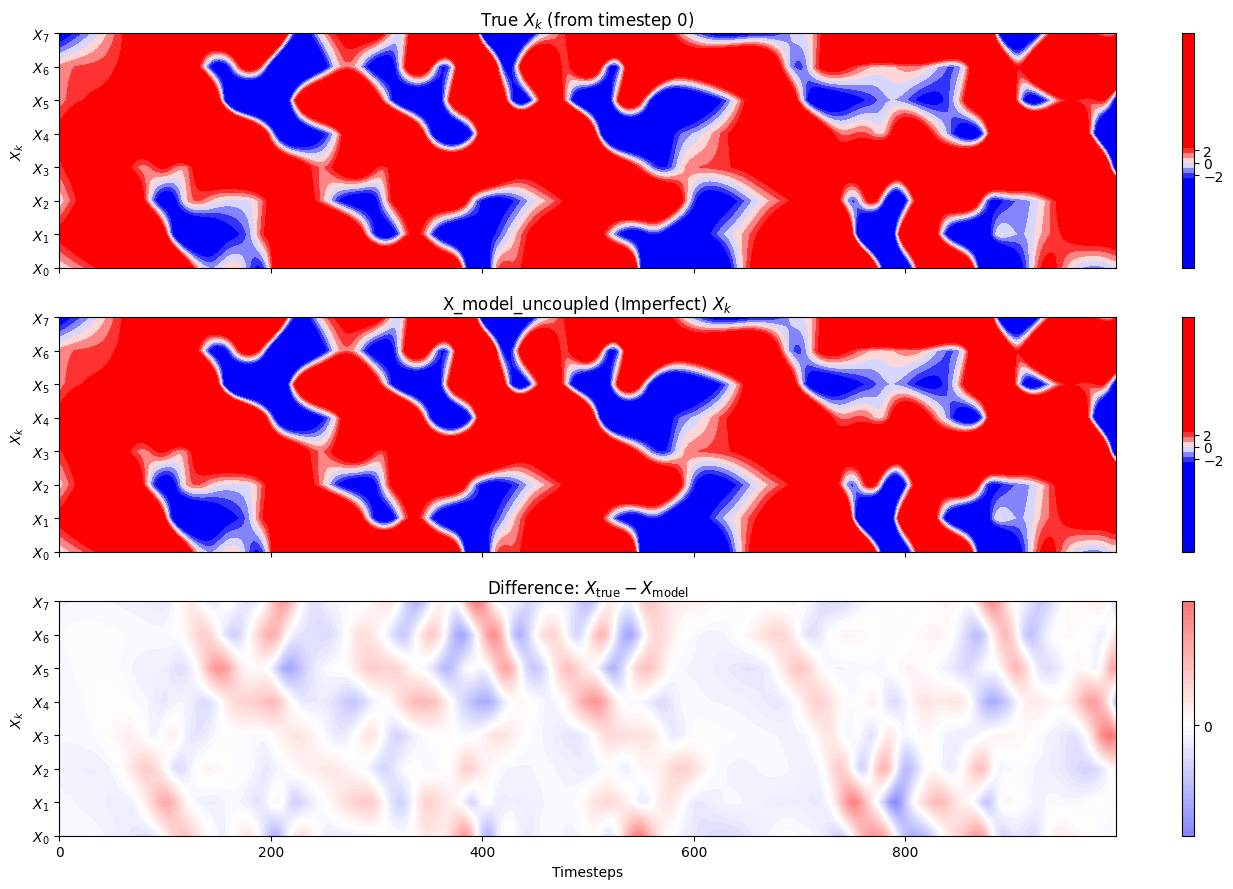

In [14]:
X_model = np.load(os.path.join(data_path, 'X_model_uncoupled.npy')).T  # Shape: (K=8, T)
X_model_plot = X_model[:, :1000]

# Load denormalized true data for comparison
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[:500000, :8].T
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
X_true = X_true * x_std.reshape(-1, 1) + x_mean.reshape(-1, 1)  # Denormalize

# Plot
plot_model_vs_truth(X_true[:, :1000], X_model[:, :1000], start=0, model_name="X_model_uncoupled (Imperfect)")

### Hybrid ESN Code

In [7]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 16, # 8 from model, 8 from data
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

In [8]:
# === Utilities ===
def generate_reservoir(size, radius, degree):
    print("Generating Reservoir")
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    eigvals = np.linalg.eigvals(A)
    A = (A / np.max(np.abs(eigvals))) * radius
    return A

def build_input_weights(N, num_inputs, sigma):
    print("Building Input Weights")
    q = int(N / num_inputs)
    Win = np.zeros((N, num_inputs))
    for i in range(num_inputs):
        np.random.seed(i)
        Win[i * q: (i + 1) * q, i] = sigma * (-1 + 2 * np.random.rand(q))
    return Win

def reservoir_layer(A, Win, X_true, X_model, res_params, states=None):
    N = res_params['N']
    T = res_params['train_length']
    K = X_true.shape[0]  # should be 8

    if states is None:
        states = np.zeros((N, T))

    for t in trange(1, T, desc="Loading Uncoupled Reservoir with X_model and X_true"):
        x_model_t = X_model[:, t]  # (8,)
        x_true_t = X_true[:, t]    # (8,)
        u_t = np.hstack([x_model_t, x_true_t])  # (16,)
        states[:, t] = np.tanh(A @ states[:, t - 1] + Win @ u_t)

    return states

def train(res_params, r_states, X_model, X_true):
    beta = res_params['beta']
    N, T = r_states.shape
    K = X_model.shape[0]

    # === Transform r_states into r_star in-place
    r_star = r_states.copy()
    for j in trange(2, N - 2, desc="Transforming r_states → r* in-place"):
        if j % 2 == 0:
            r_star[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

    # === Design matrix: [X_model; r*] shape → (K + N, T)
    X = np.vstack([X_model, r_star])  # (K + N, T)
    Y = X_true                          # (K, T)

    # === Tikhonov regularization (ridge regression)
    I = beta * np.identity(K + N)        # Dense identity matrix
    U = np.dot(X, X.T) + I
    W_out = np.dot(np.linalg.inv(U), np.dot(X, Y.T))  # (K + N, K)
    # W_out = np.linalg.solve(U, X @ Y.T)

    return W_out.T  # shape: (K, K + N)


def train_gpu(res_params, r_states, X_model, X_true):
    beta = res_params['beta']
    N, T = r_states.shape
    K = X_model.shape[0]  # Assuming shape (K, T)

    # === Convert to CuPy arrays
    r_states = cp.asarray(r_states)
    X_model = cp.asarray(X_model)
    X_true = cp.asarray(X_true)

    # === Transform r_states → r* in-place
    for j in trange(2, N - 2, desc="Transforming r_states → r* in-place (GPU)"):
        if j % 2 == 0:
            r_states[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

    # === Stack input features: [X_model; r*] → (K + N, T)
    X = cp.vstack([X_model, r_states])
    Y = X_true

    # === Ridge Regression
    I = beta * cp.identity(K + N)
    U = X @ X.T + I
    # W_out = cp.dot(cp.linalg.inv(U), cp.dot(X, Y.T))
    W_out = cp.linalg.solve(U, X @ Y.T)  # (K + N, K)

    return cp.asnumpy(W_out.T)  # shape: (K, K + N)

### Generate A and Win

In [10]:
# === Generate Reservoir Matrices ===
A = generate_reservoir(res_params['N'], res_params['radius'], res_params['degree'])
Win = build_input_weights(res_params['N'], res_params['num_inputs'], res_params['sigma'])

# Check shapes
print("A shape  :", A.shape)     # (4992, 4992)
print("Win shape:", Win.shape)   # (4992, 16)

Generating Reservoir
Building Input Weights
A shape  : (4992, 4992)
Win shape: (4992, 16)


In [11]:
# === Save Checkpoint (A, Win)
checkpoint_file = os.path.join(checkpoints_path, 'hybrid_checkpoint_latest')
np.savez_compressed(checkpoint_file, A=A, Win=Win)
print(f"Saved A and Win to {checkpoint_file}")

Saved A and Win to /content/drive/My Drive/AM170B Project/checkpoints/hybrid_checkpoint_latest


### Generate Reservoir States

In [9]:
checkpoint = np.load(os.path.join(checkpoints_path, f'hybrid_checkpoint_latest.npz'))
A = checkpoint['A']
Win = checkpoint['Win']

# Check shapes
print("A shape  :", A.shape)     # (4992, 4992)
print("Win shape:", Win.shape)   # (4992, 16)

A shape  : (4992, 4992)
Win shape: (4992, 16)


In [10]:
# === Load True Data and Imperfect Model Data ===
start = 0
end = 500000

X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[start:end, :K].T  # shape (8, T)
X_model = np.load(os.path.join(data_path, 'X_model_uncoupled.npy'), mmap_mode='r')[start:end].T         # shape (8, T)

In [11]:
print("X_true shape: ", X_true.shape)    # (8, 500000)
print("X_model shape:", X_model.shape)   # (8, 500000)

X_true shape:  (8, 500000)
X_model shape: (8, 500000)


In [16]:
r_states = reservoir_layer(A, Win, X_true, X_model, res_params)

Loading Uncoupled Reservoir with X_model and X_true: 100%|██████████| 499999/499999 [32:22<00:00, 257.42it/s]


In [17]:
print("r_states shape:   ", r_states.shape)     # → (N, T)

r_states shape:    (4992, 500000)


In [18]:
# === Save as .npy for mmap_mode use
r_state_file_npy = os.path.join(states_path, 'r_states_hybrid')
np.save(r_state_file_npy, r_states)  # Will become 'r_states_hybrid.npy'

# === Save as .npz for backup/inspection
r_state_file_npz = os.path.join(states_path, 'r_states_hybrid_backup.npz')
np.savez_compressed(r_state_file_npz, r_states=r_states)

print(f"Saved reservoir states to:")
print(f" - {r_state_file_npy}.npy (for mmap)")
print(f" - {r_state_file_npz} (compressed backup)")
os.listdir(states_path)

KeyboardInterrupt: 

### Generate Reservoir States with Normalized Data

In [18]:
# Load denormalized predictions
X_model_uncoupled = np.load(os.path.join(data_path, 'X_model_uncoupled.npy'))  # shape: (T, 8)

# Load normalization constants
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']

# Normalize
X_model_normalized = (X_model_uncoupled - x_mean) / x_std  # shape: (T, 8)

# Save normalized version for training
np.save(os.path.join(data_path, 'X_model_normalized.npy'), X_model_normalized)
print("Saved normalized version to X_model_normalized.npy")

Saved normalized version to X_model_normalized.npy


In [9]:
# === Load normalized model data and true data
X_model = np.load(os.path.join(data_path, 'X_model_normalized.npy'))[:res_params['train_length']].T  # shape (K, T)
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[:res_params['train_length'], :8].T

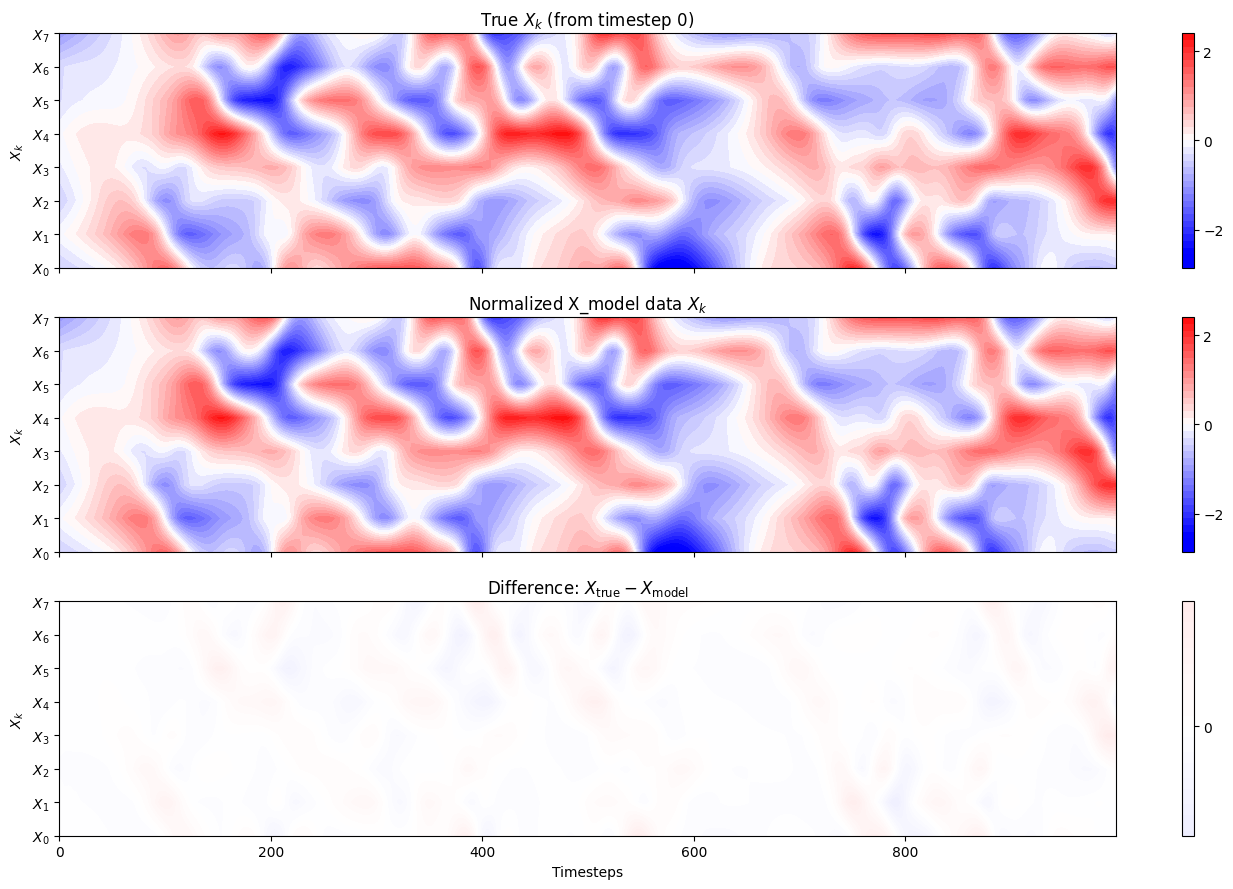

In [10]:
plot_model_vs_truth(X_true[:, :1000], X_model[:, :1000], start=0, model_name="Normalized X_model data")

In [11]:
# === Load trained model (same A and Win as used in training)
model = np.load(os.path.join(models_path, f'hybrid_model_{500000}_uncoupled.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']  # Not used here, but kept for completeness

In [12]:
# === Generate reservoir states
r_states = reservoir_layer(A, Win, X_true, X_model, res_params)  # shape: (N, T)

Loading Uncoupled Reservoir with X_model and X_true: 100%|██████████| 499999/499999 [38:12<00:00, 218.07it/s]


In [13]:
# === Save reservoir states for future use
r_state_file_npy = os.path.join(states_path, 'r_states_hybrid_norm')
np.save(r_state_file_npy, r_states)  # → .npy (for mmap)

print("Saved reservoir states to:")
print(f" - {r_state_file_npy}.npy (for mmap)")
print("Available files in states_path:", os.listdir(states_path))

Saved reservoir states to:
 - /content/drive/My Drive/AM170B Project/hybrid_states/r_states_hybrid_norm.npy (for mmap)
Available files in states_path: ['r_states_hybrid.npy', 'r_states_hybrid_norm.npy']


### Train Model De-Normalized

In [12]:
train_length = 500000
res_params['train_length'] = train_length
r_states = np.load(os.path.join(states_path, 'r_states_hybrid.npy'), mmap_mode='r')[:, :train_length]
X_model = np.load(os.path.join(data_path, 'X_model_uncoupled.npy'), mmap_mode='r')[:train_length].T  # shape: (8, T)
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[:train_length, :K].T  # shape: (8, T)

In [13]:
print("r_states shape:   ", r_states.shape)     # → (N, T)
print("X_model shape:    ", X_model.shape)      # → (8, T)
print("X_true shape:     ", X_true.shape)       # → (8, T)

r_states shape:    (4992, 500000)
X_model shape:     (8, 500000)
X_true shape:      (8, 500000)


In [14]:
checkpoint = np.load(os.path.join(checkpoints_path, f'hybrid_checkpoint_latest.npz'))
A = checkpoint['A']
Win = checkpoint['Win']

# Check shapes
print("A shape  :", A.shape)     # (4992, 4992)
print("Win shape:", Win.shape)   # (4992, 16)

A shape  : (4992, 4992)
Win shape: (4992, 16)


In [16]:
W_out = train_gpu(res_params, r_states, X_model, X_true)

Transforming r_states → r* in-place (GPU): 100%|██████████| 4988/4988 [00:00<00:00, 5976.73it/s]


In [19]:
model_file = os.path.join(models_path, f'hybrid_model_{train_length}_uncoupled.npz')
np.savez_compressed(model_file, A=A, Win=Win, W_out=W_out)

### Train Normalized Model

In [10]:
# Set training length
train_length = 500000
res_params['train_length'] = train_length

# Load r_states (generated from normalized X_model)
r_states = np.load(os.path.join(states_path, 'r_states_hybrid_norm.npy'), mmap_mode='r')[:, :train_length]

# Load X_model (denormalized predictions, but reservoir was trained on normalized)
X_model = np.load(os.path.join(data_path, 'X_model_uncoupled.npy'), mmap_mode='r')[:train_length].T  # shape: (8, T)

# Load X_true (truth is in normalized form already)
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[:train_length, :K].T  # shape: (8, T)

# Sanity check
print("r_states shape:   ", r_states.shape)   # (N, T)
print("X_model shape:    ", X_model.shape)    # (8, T)
print("X_true shape:     ", X_true.shape)     # (8, T)

r_states shape:    (4992, 500000)
X_model shape:     (8, 500000)
X_true shape:      (8, 500000)


In [11]:
checkpoint = np.load(os.path.join(checkpoints_path, f'hybrid_checkpoint_latest.npz'))
A = checkpoint['A']
Win = checkpoint['Win']

print("A shape  :", A.shape)
print("Win shape:", Win.shape)

A shape  : (4992, 4992)
Win shape: (4992, 16)


In [12]:
W_out = train_gpu(res_params, r_states, X_model, X_true)

Transforming r_states → r* in-place (GPU): 100%|██████████| 4988/4988 [00:00<00:00, 6833.26it/s]


In [13]:
model_file = os.path.join(models_path, f'hybrid_model_{train_length}_normalized.npz')
np.savez_compressed(model_file, A=A, Win=Win, W_out=W_out)

### Predict Denormalized

In [9]:
def predict_hybrid_uncoupled(A, Win, W_out, r_state, X_init, Y_init, res_params):
    print("Running Uncoupled Hybrid X-only Prediction")

    K = 8      # X dimension
    J = 8      # number of Y_j per X
    N = res_params['N']
    T_pred = res_params['predict_length']
    dt = 0.005

    # Allocate
    print("Allocating Memory")
    X_preds = np.zeros((K, T_pred))
    X_model_preds = np.zeros((K, T_pred))
    r = r_state.copy()
    X_model = X_init.copy()
    Y_model = Y_init.copy()

    for t in tqdm(range(T_pred), desc="Predicting X only"):
        # === r* transformation
        r_aug = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_aug[j] = r[j - 1] * r[j - 2]

        # === Hybrid model prediction
        hybrid_input = np.hstack([X_model, r_aug])  # (8 + 8 + N,)
        X = W_out @ hybrid_input  # output new X only (8,)

        # === Save results
        X_preds[:, t] = X
        X_model_preds[:, t] = X_model

        # === Update reservoir with uncoupled input
        u = np.hstack([X_model, X])  # same input structure as training
        r = np.tanh(A @ r + Win @ u)

        # === Imperfect model rollout (in real space)
        X_model, Y_model = x_step(X_model, Y_model, dt)  # imperfect model advances recursively


    print("\n=== Prediction Complete ===")
    print("X_preds shape:", X_preds.shape)
    print("X_model_preds shape:", X_model_preds.shape)

    return X_preds, X_model_preds

In [10]:
# === Load trained model
model = np.load(os.path.join(models_path, f'hybrid_model_{500000}_uncoupled.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# === Load final reservoir state from training
start_idx = 499999
r_idx = 499999  # Use last step from training
r_state = np.load(os.path.join(states_path, 'r_states_hybrid.npy'), mmap_mode='r')[:, r_idx]

# === Load initial condition
data = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')
X_init = data[r_idx, :K]
Y_init = data[r_idx, K:].reshape(J, K, order='F')

# === Load Normalization Constants ===
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

# === Denormalize to real space
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']
X_init_real = X_init * x_std + x_mean
Y_init_real = Y_init * y_std + y_mean

In [11]:
# === Sanity checks
print("W_out shape       :", W_out.shape)        # (8, 5000)
print("r_state shape     :", r_state.shape)      # (4992,)
print("X_init_real shape :", X_init_real.shape)  # (8,)
print("Y_init_real shape :", Y_init_real.shape)  # (8, 8)
print("A shape           :", A.shape)            # (4992, 4992)
print("Win shape         :", Win.shape)          # (4992, 16)

W_out shape       : (8, 5000)
r_state shape     : (4992,)
X_init_real shape : (8,)
Y_init_real shape : (8, 8)
A shape           : (4992, 4992)
Win shape         : (4992, 16)


In [12]:
# === Run prediction ===
X_preds, X_model_preds = predict_hybrid_uncoupled(
    A=A,
    Win=Win,
    W_out=W_out,
    r_state=r_state,
    X_init=X_init_real,
    Y_init=Y_init_real,
    res_params=res_params
)

Running Uncoupled Hybrid X-only Prediction
Allocating Memory


Predicting X only: 100%|██████████| 1000/1000 [00:05<00:00, 172.72it/s]


=== Prediction Complete ===
X_preds shape: (8, 1000)
X_model_preds shape: (8, 1000)


In [14]:
# === Load corresponding ground truth ===
truth_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
X_true = np.load(truth_path, mmap_mode='r')[start_idx : start_idx + res_params['predict_length'], :K].T  # shape: (8, T)

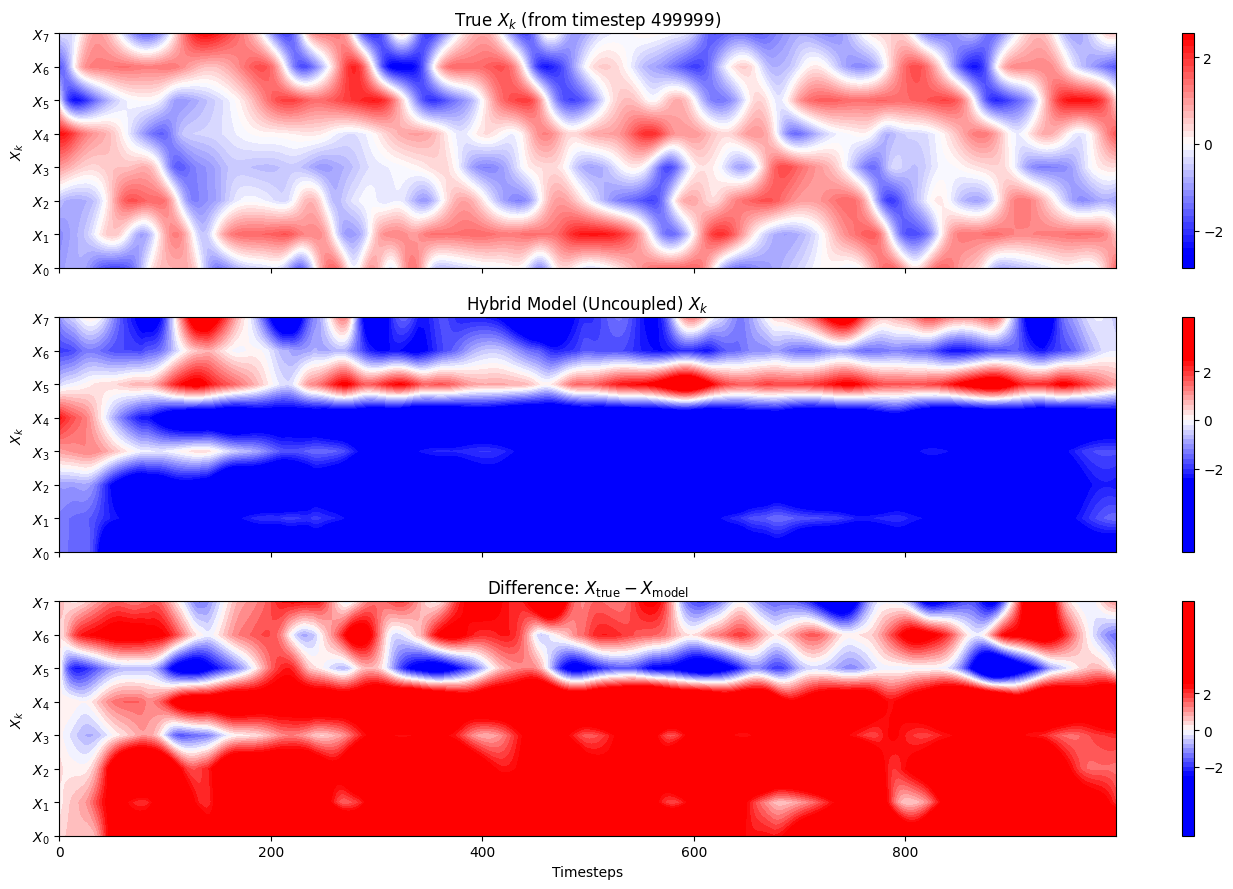

In [15]:
plot_model_vs_truth(X_true, X_preds, start=start_idx, model_name="Hybrid Model (Uncoupled)", valid_time=None)

In [16]:
# Renormalize X_model_preds so it's in the same scale as W_out's outputs
X_model_preds_norm = (X_model_preds - x_mean.reshape(-1, 1)) / x_std.reshape(-1, 1)

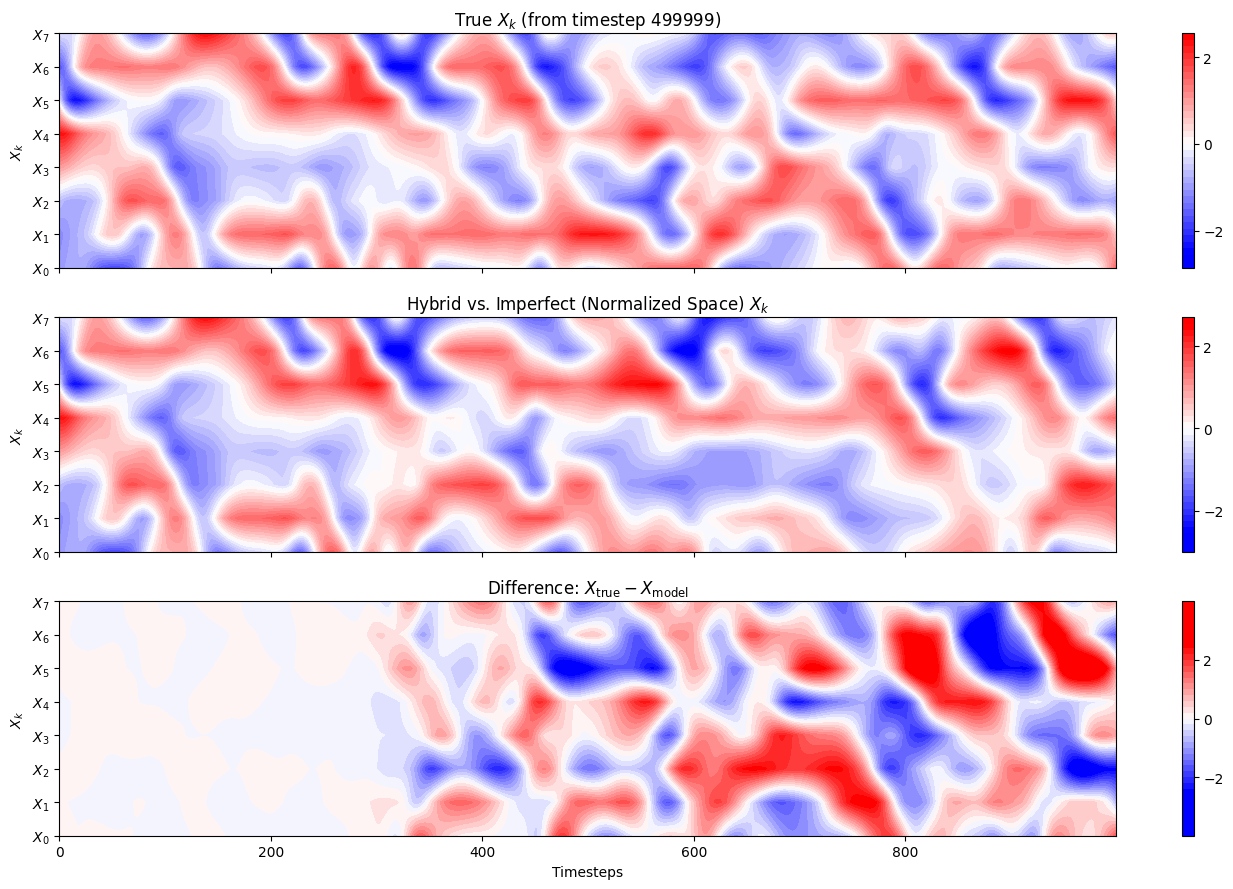

In [17]:
plot_model_vs_truth(X_true, X_model_preds_norm, start=start_idx, model_name="Hybrid vs. Imperfect (Normalized Space)")

In [25]:
save_path = os.path.join(predictions_path, f"hybrid_preds_{start_idx}_uncoupled.npz")
np.savez_compressed(save_path, X_preds=X_preds)
print(f"Saved hybrid prediction to {save_path}")

Saved hybrid prediction to /content/drive/My Drive/AM170B Project/predictions/hybrid_preds_499999_uncoupled.npz


### Predict Normalized

In [16]:
def predict_hybrid_normalized(A, Win, W_out, r_state, X_init, Y_init, res_params, x_mean, x_std, y_mean, y_std):
    print("Running Normalized Hybrid X-only Prediction")

    K = 8      # X dimension
    J = 8      # number of Y_j per X
    N = res_params['N']
    T_pred = res_params['predict_length']
    dt = 0.005

    # Allocate
    print("Allocating Memory")
    X_preds = np.zeros((K, T_pred))
    X_model_preds = np.zeros((K, T_pred))
    r = r_state.copy()
    X_model = X_init.copy()
    Y_model = Y_init.copy()

    for t in tqdm(range(T_pred), desc="Predicting X only"):
        # === Imperfect model rollout (normalized space)
        X_model, Y_model = imperfect_model(X_model, Y_model, x_mean, x_std, y_mean, y_std, dt)

        # === r* transformation
        r_aug = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_aug[j] = r[j - 1] * r[j - 2]

        # === Hybrid model prediction
        hybrid_input = np.hstack([X_model, r_aug])  # (8 + N,)
        X = W_out @ hybrid_input

        # === Save results
        X_preds[:, t] = X
        X_model_preds[:, t] = X_model

        # === Update reservoir
        u = np.hstack([X_model, X])
        r = np.tanh(A @ r + Win @ u)

    print("\n=== Prediction Complete ===")
    print("X_preds shape:", X_preds.shape)
    print("X_model_preds shape:", X_model_preds.shape)

    return X_preds, X_model_preds

In [10]:
# Load trained model
model = np.load(os.path.join(models_path, f"hybrid_model_{500000}_normalized.npz"))
A = model["A"]
Win = model["Win"]
W_out = model["W_out"]

In [12]:
# Load final r_state from training
start_idx = 499999
r_state = np.load(os.path.join(states_path, 'r_states_hybrid_norm.npy'), mmap_mode='r')[:, start_idx]

# Load normalized initial condition
data = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')
X_init = data[start_idx, :K]  # already normalized
Y_init = data[start_idx, K:].reshape(J, K, order='F')  # already normalized

# Load normalization constants
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

In [17]:
X_preds, X_model_preds = predict_hybrid_normalized(
    A=A,
    Win=Win,
    W_out=W_out,
    r_state=r_state,
    X_init=X_init,
    Y_init=Y_init,
    res_params=res_params,
    x_mean=x_mean,
    x_std=x_std,
    y_mean=y_mean,
    y_std=y_std
)

Running Normalized Hybrid X-only Prediction
Allocating Memory


Predicting X only: 100%|██████████| 1000/1000 [00:07<00:00, 129.22it/s]


=== Prediction Complete ===
X_preds shape: (8, 1000)
X_model_preds shape: (8, 1000)


### Plot Denormalized Predictions

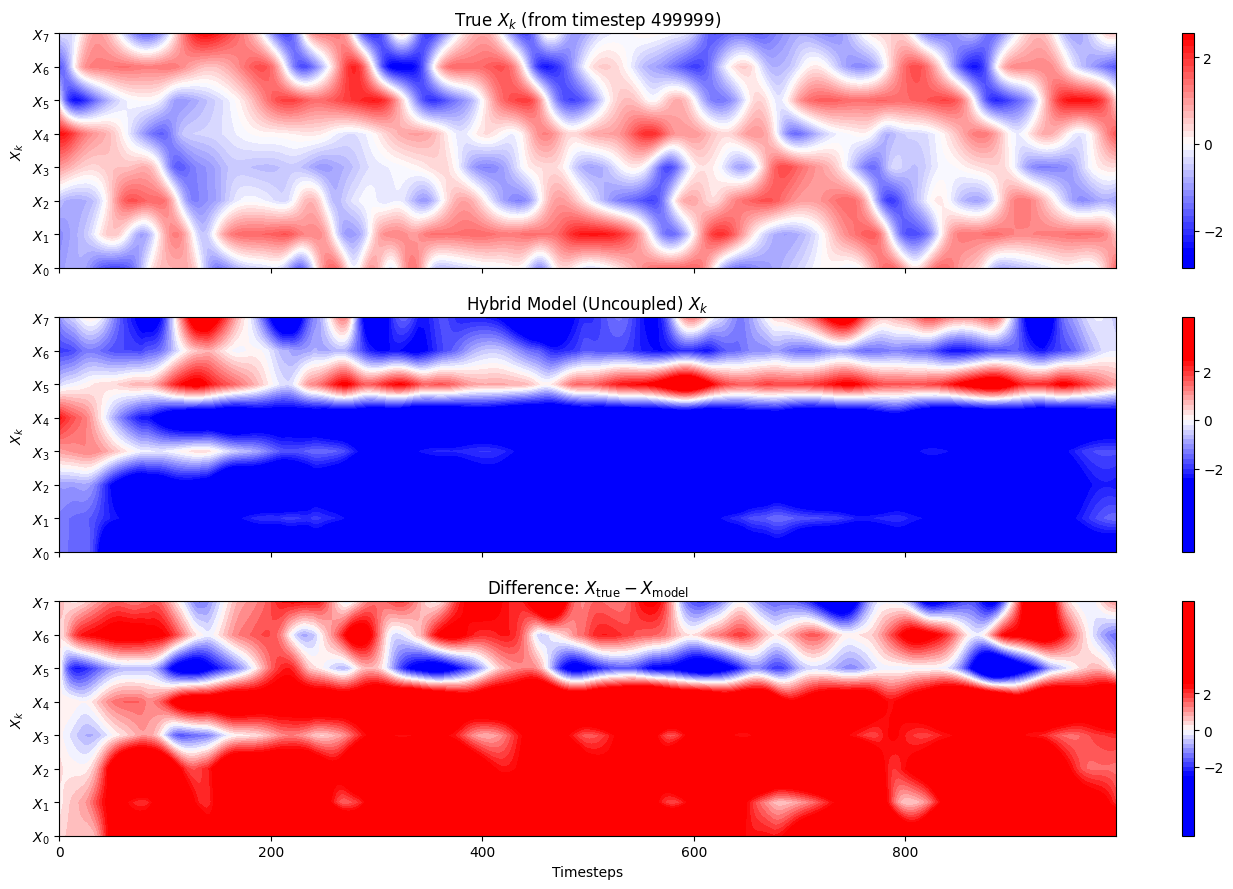

In [26]:
# === Load predicted data ===
pred_file = os.path.join(predictions_path, f"hybrid_preds_{start_idx}_uncoupled.npz")
preds = np.load(pred_file)
X_pred = preds['X_preds']  # shape (8, T)

# === Load corresponding ground truth ===
truth_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
X_true = np.load(truth_path, mmap_mode='r')[start_idx : start_idx + res_params['predict_length'], :K].T  # shape: (8, T)

# === Plot model vs. ground truth ===
plot_model_vs_truth(X_true, X_pred, start=start_idx, model_name="Hybrid Model (Uncoupled)", valid_time=None)

In [12]:
# Load hybrid training data
r_states = np.load(os.path.join(states_path, 'r_states_hybrid.npy'), mmap_mode='r')  # (N, T)
X_model = np.load(os.path.join(data_path, 'X_model_uncoupled.npy'), mmap_mode='r').T            # (K=8, T)
X_true = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[:500000, :8].T
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
# x_mean, x_std = norms['x_mean'], norms['x_std']
# X_true = X_true * x_std.reshape(-1, 1) + x_mean.reshape(-1, 1)  # Denormalize


In [6]:
N, T = r_states.shape
r_star = r_states.copy()
for j in range(2, N - 2):
    if j % 2 == 0:
        r_star[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

In [7]:
# === Load trained model
model = np.load(os.path.join(models_path, f'hybrid_model_{500000}_uncoupled.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

In [8]:
X_input = np.vstack([X_model, r_star])       # shape: (K + N, T)
X_preds = W_out @ X_input                    # shape: (K, T)

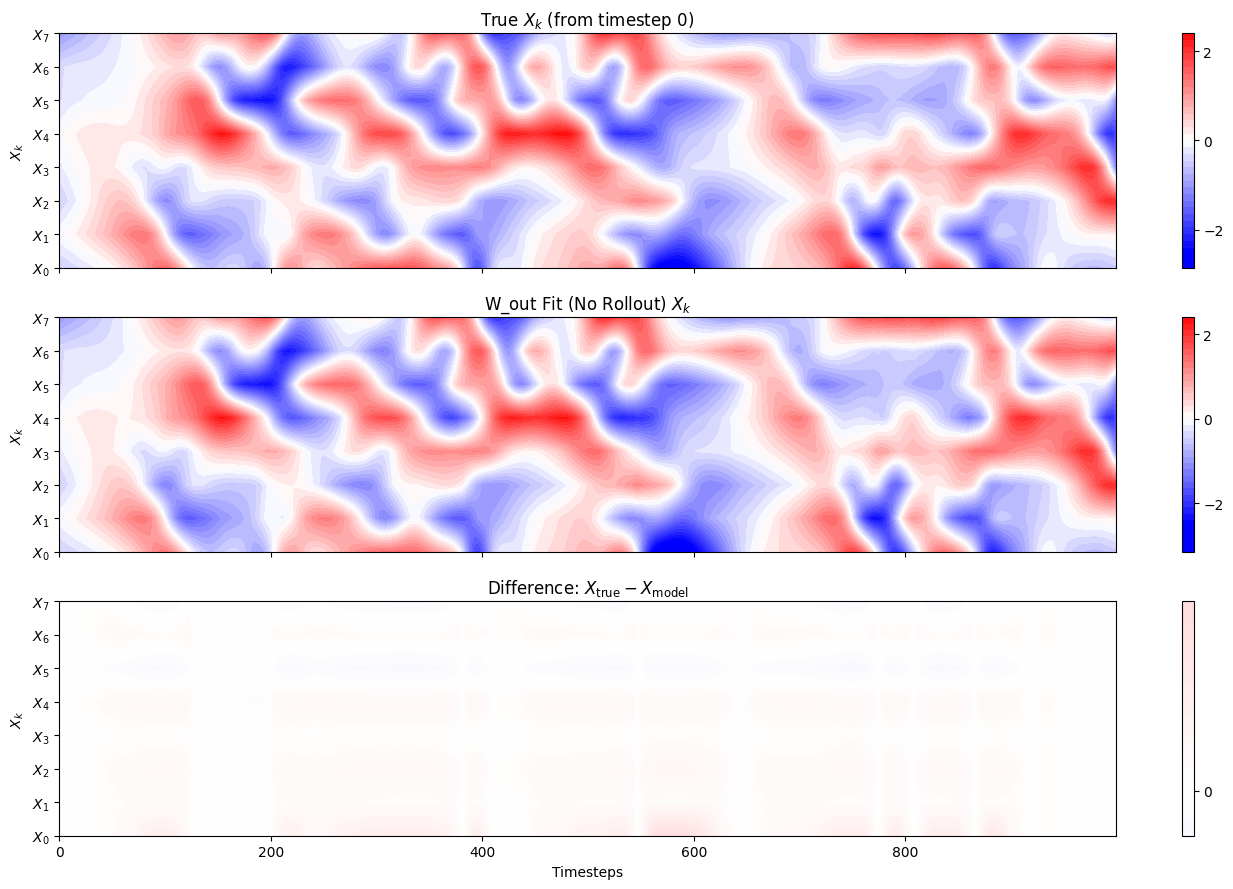

In [13]:
plot_model_vs_truth(X_true[:, :1000], X_preds[:, :1000], start=0, model_name="W_out Fit (No Rollout)")

### Plot Normalized Predictions

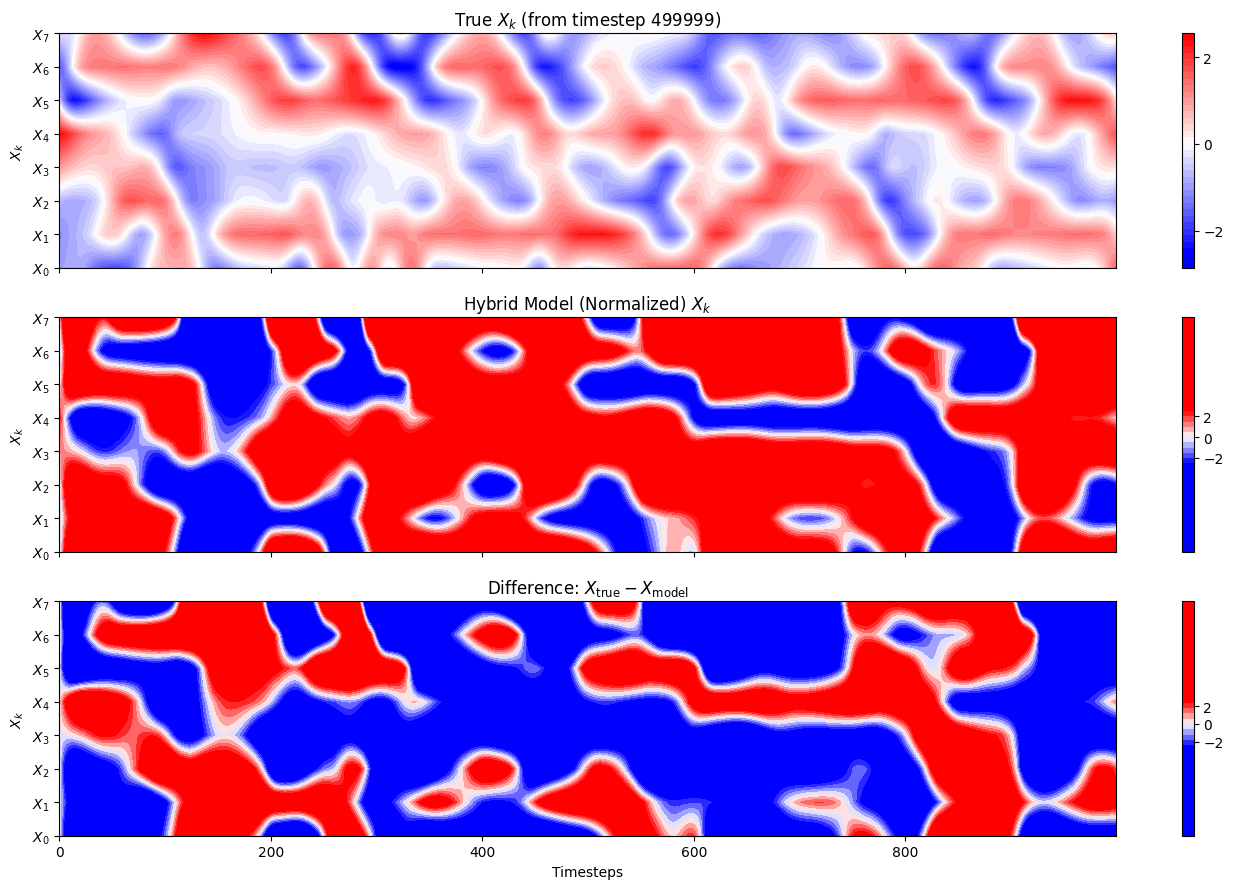

In [18]:
# Load ground truth for plotting
X_true = data[start_idx + 1 : start_idx + 1 + res_params['predict_length'], :K].T  # shape: (8, T)

# Plot Hybrid vs Truth
plot_model_vs_truth(X_true, X_preds, start=start_idx, model_name="Hybrid Model (Normalized)")